#### leer este paper https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6119093/

In [87]:
import sys
sys.path.append('/workspaces/bha2/src')

In [88]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [89]:
import os
import abagen
import nibabel as nib
import seaborn as sns
from statsmodels.stats.multitest import multipletests
import numpy as np
import matplotlib.pyplot as plt
from ni_functions import *

In [5]:
project_path = "/workspaces/bha2"
conn_size = 2165

In [51]:
atlas_name = "craddock_" + str(conn_size) + ".nii.gz"
atlas = nib.load(os.path.join(project_path, "brain_templates", atlas_name))
atlas_vol = atlas.get_fdata()
optimal_parcellation = nib.load(os.path.join(project_path, "data", "results", "n" + str(conn_size), "optimal_partition.nii.gz"))
optimal_parcellation_data = optimal_parcellation.get_fdata()
module_sizes = nib.load(os.path.join(project_path, "data", "results", "n" + str(conn_size), "module_sizes.nii.gz")).get_fdata()
module_heights = nib.load(os.path.join(project_path, "data", "results", "n" + str(conn_size), "module_heights.nii.gz")).get_fdata()
module_MSI = nib.load(os.path.join(project_path, "data", "results", "n" + str(conn_size), "MSI.nii.gz")).get_fdata()
module_idx = np.setdiff1d(np.unique(optimal_parcellation_data), [0]).astype(int)

In [61]:
parcel = np.zeros(optimal_parcellation_data.shape)
parcel_rois = []
idx_parcel = 1
heights_values = []
MSI_values = []
for idx in module_idx:
    module_vol = optimal_parcellation_data == idx
    m_size = np.setdiff1d(np.unique(module_sizes[module_vol]), [0])
    if m_size > 10:
        parcel[module_vol] = idx_parcel
        parcel_rois.append(get_atlas_rois_from_mask(nib.Nifti1Image(module_vol*1.0, affine=optimal_parcellation.affine), atlas))
        heights_values.append(module_heights[module_vol][0])
        MSI_values.append(module_MSI[module_vol][0])
        idx_parcel += 1
parcel_img = nib.Nifti1Image(parcel, affine=optimal_parcellation.affine)


<Axes: >

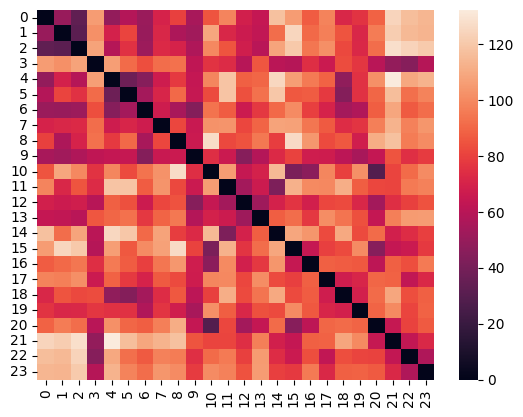

In [65]:
distance_matrix = np.zeros((len(parcel_rois), len(parcel_rois)))
for i in range(len(parcel_rois)):
    for j in range(len(parcel_rois)):
        if i == j:
            distance_matrix[i, j] = 0
        else:
            distance_matrix[i, j] = distance_between_modules(parcel_rois[i], parcel_rois[j], atlas)
sns.heatmap(distance_matrix)

In [158]:
# check if fcm and scm are stored in tmp folder
if os.path.exists(os.path.join(project_path, "tmp", "transcriptome_" + str(len(parcel_rois)) + "modules.npy")):
    tanscriptome = np.load(os.path.join(project_path, "tmp", "transcriptome_" + str(len(parcel_rois)) + "modules.npy"))
    print("tanscriptome loaded from tmp folder")
else:
    tanscriptome = pd.DataFrame.transpose(abagen.get_expression_data(parcel_img))
    np.save(os.path.join(project_path, "tmp", "transcriptome_" + str(len(parcel_rois)) + "modules.npy"), tanscriptome)

tanscriptome loaded from tmp folder


(15633, 24)


<Axes: >

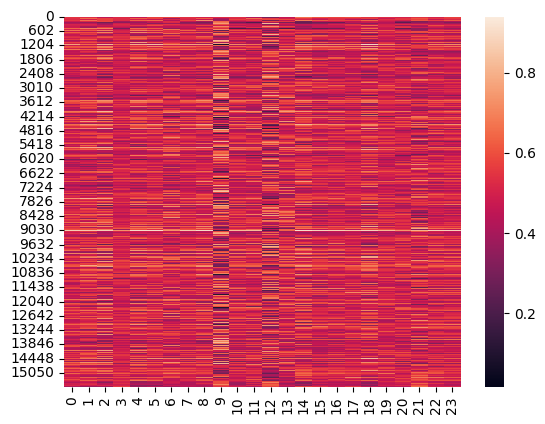

In [159]:
print(tanscriptome.shape)
sns.heatmap(tanscriptome)

In [166]:
brain_genes = pd.read_csv(os.path.join(project_path, "data", "tissue_category_rna_brain_Tissue.tsv"), sep="\t")
brain_gene_names = brain_genes["Gene"].values
brain_gene_expresion = exp.loc[exp.index.isin(brain_gene_names), :]


In [167]:
#compute the pearson correlation between expression and MSI in an effcient way
corr = np.zeros((brain_gene_expresion.shape[0], 2))
for i in range(brain_gene_expresion.shape[0]):
    corr[i, 0] = np.corrcoef(brain_gene_expresion.values[i, :], MSI_values)[0, 1]
    corr[i, 1] = np.corrcoef(brain_gene_expresion.values[i, :], heights_values)[0, 1]
    

In [132]:
p_MSI, t_MSI = regression_with_transcriptome(np.array(MSI_values), brain_gene_expresion.values, distance_matrix)
pfdr_MSI = multipletests(p_MSI, alpha=0.05, method='fdr_bh', is_sorted=False)

/usr/local/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 6 disconnected components.
  warnings.warn(message)
/usr/local/lib/python3.9/site-packages/libpysal/weights/util.py:855: UserWarning: This function is deprecated. Use fill_diagonal instead.
  warn("This function is deprecated. Use fill_diagonal instead.")
/usr/local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:870: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "


In [155]:
brain_gene_names[np.where(corr[:,0]<-0.4)]

array(['GPR101', 'H4C8', 'DRGX', 'MDGA1', 'RBFOX1', 'IGSF1', 'OXTR',
       'NPAS4', 'KCNJ9', 'NANOS3', 'GHSR', 'GLRA3', 'KIF1A', 'NDST3',
       'NSG2', 'NSMF', 'ZCCHC12', 'IFITM10', 'L1TD1', 'RGS4',
       'AC011448.1', 'ADORA3', 'ANKRD36', 'BEND4', 'BRINP2', 'C1orf216',
       'C1QTNF4', 'CADM3', 'CDH23', 'CLEC3A', 'CORO2B', 'CRACDL', 'CREB5',
       'CRYBB2', 'DNAJA1', 'FN3K', 'GDAP1', 'GSX2', 'H2BW2', 'HSF4',
       'ILDR2', 'KCNC3', 'KLC1', 'LYG2', 'MINAR1', 'MLLT11', 'MRO',
       'NDRG2', 'NFASC'], dtype=object)